In [149]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import Normalizer
import random
%matplotlib inline

In [150]:
args = {'lr':0.01,
        'train epochs':500,
        'hidden layers':15,
        'noise':0.01,
        'train size':0.7,
        'spec scale':10**12,
        'train criterion':nn.L1Loss(),
        'test criterion':nn.L1Loss(),
        'scaler':RobustScaler(),
        'big hidden layers':15
        }

# Data Prep

In [151]:
# define layer dictionary to store per layer info
layers = []
for i in range(1,12):
    layers.append({'layer':i,
                   'col': f'layer {i}'})

In [152]:
df = pd.read_excel('wide_range.xlsx')

In [153]:
# spectrum data
X = df.iloc[:,11:]

# layer data
y = df.iloc[:,:11]

In [154]:
# scale by 10^12
X = X.apply(lambda x: x*args['spec scale'])

In [155]:
# scale for training
scaler = args['scaler']
scaler.fit(X)
X_scaled = scaler.transform(X)


X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

In [156]:
def add_noise(data, percentage):
    std_dev = percentage
    noise = np.random.normal(0, std_dev, data.shape)
    noisy_data = data + noise
    return noisy_data

In [157]:
# add noise
X_noisy = add_noise(X, args['noise'])

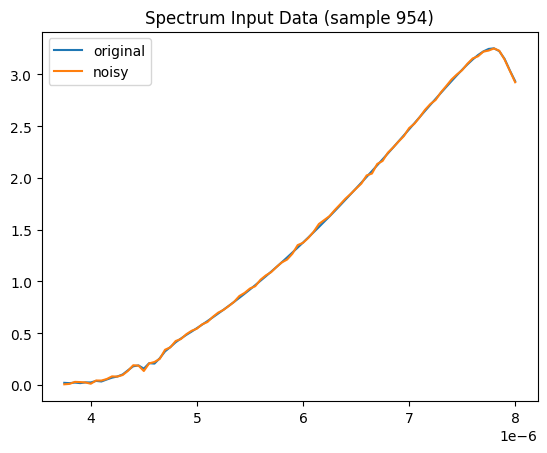

In [158]:
entry = random.randint(0, len(X))
plt.title(f'Spectrum Input Data (sample {entry})')
plt.plot(X.iloc[entry], label='original')
plt.plot(X_noisy.iloc[entry], label='noisy')
plt.legend()
plt.show()

In [159]:
scaler = args['scaler']
scaler.fit(X_noisy)
X_noisy_scaled = scaler.transform(X_noisy)

X_noisy_scaled_df = pd.DataFrame(X_noisy_scaled, columns=X.columns)

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X_noisy_scaled_df, y, train_size=args['train size'], random_state=101)

In [161]:
for layer in layers:
    layer['y_train'] = torch.tensor(y_train[layer['col']].values, dtype=torch.float32).reshape(-1,1)
    layer['y_test'] = torch.tensor(y_test[layer['col']].values, dtype=torch.float32).reshape(-1,1)

In [162]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [163]:
class FeedForward(nn.Module):
    def __init__(self, input_size, output_size, num_hidden):
        super(FeedForward, self).__init__()
        
        hidden_sizes = [input_size]
        step = input_size / (num_hidden+1)

        for i in range(num_hidden):
            hidden_size = int(input_size - (i+1) * step)
            if hidden_size < 1: hidden_size = 1
            hidden_sizes.append(hidden_size)
        
        self.hidden_layers = nn.ModuleList()

        for i in range(num_hidden):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))

        self.hidden_sizes = hidden_sizes
        self.lin_fin = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        for hidden_layer in self.hidden_layers:
            x = F.leaky_relu(hidden_layer(x))
        x = self.lin_fin(x)
        return x

In [164]:
class BigNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(BigNet, self).__init__()
        self.lin1 = nn.Linear(input_size, 80)
        self.lin2 = nn.Linear(80, 60)
        self.lin3 = nn.Linear(60, 40)
        self.lin4 = nn.Linear(40, 20)
        self.lin_fin = nn.Linear(20, output_size)

    def forward(self, x):
        x = F.leaky_relu(self.lin1(x))
        x = F.leaky_relu(self.lin2(x))
        x = F.leaky_relu(self.lin3(x))
        x = F.leaky_relu(self.lin4(x))
        x = self.lin_fin(x)
        return x

In [165]:
criterion = args['train criterion']

In [166]:
print("Individual Layer Training")
for layer in layers:
    features = X_train_tensor
    target = layer['y_train']

    # instantiate model
    model = FeedForward(features.size()[1], target.size()[1], args['hidden layers'])

    best_loss = np.inf
    best_epoch = 0
    train_losses = []

    optimizer = torch.optim.Rprop(model.parameters(), lr=args['lr'])

    print(layer['col'])
    print(f'hidden layer sizes: {model.hidden_sizes}')

    for epoch in range(args['train epochs']):
        # forward pass
        outputs = model(features)

        # get loss
        loss = criterion(outputs, target)

        # update and backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_epoch = epoch+1

        if (epoch+1) % int(args['train epochs']/10) == 0:
            print(f'epoch: {epoch+1}, loss = {loss}')

    # store model and losses
    layer['model'] = model
    layer['train losses'] = train_losses

    print(f'best loss: {best_loss} in epoch {best_epoch}\n')    

Individual Layer Training
layer 1
hidden layer sizes: [86, 80, 75, 69, 64, 59, 53, 48, 43, 37, 32, 26, 21, 16, 10, 5]
epoch: 50, loss = 28.026702880859375
epoch: 100, loss = 9.78042221069336
epoch: 150, loss = 8.955344200134277
epoch: 200, loss = 7.830694675445557
epoch: 250, loss = 7.589137554168701
epoch: 300, loss = 7.439059257507324
epoch: 350, loss = 7.328726768493652
epoch: 400, loss = 7.237817287445068
epoch: 450, loss = 7.126041412353516
epoch: 500, loss = 7.079974174499512
best loss: 7.079974174499512 in epoch 500

layer 2
hidden layer sizes: [86, 80, 75, 69, 64, 59, 53, 48, 43, 37, 32, 26, 21, 16, 10, 5]
epoch: 50, loss = 34.557525634765625
epoch: 100, loss = 9.657853126525879
epoch: 150, loss = 8.530584335327148
epoch: 200, loss = 8.104365348815918
epoch: 250, loss = 7.842356204986572
epoch: 300, loss = 7.706830024719238
epoch: 350, loss = 7.590510368347168
epoch: 400, loss = 7.519696235656738
epoch: 450, loss = 7.458324432373047
epoch: 500, loss = 7.423879623413086
best los

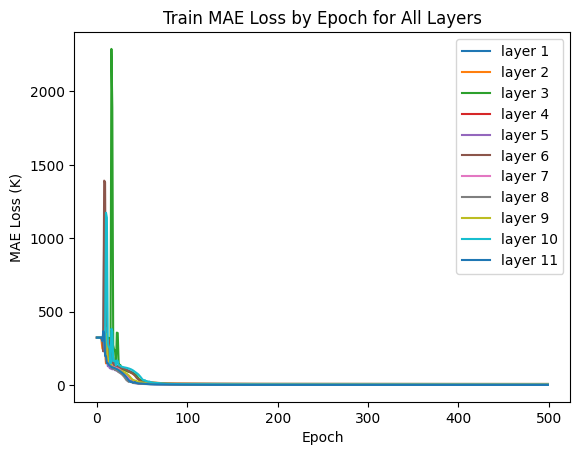

In [167]:
for layer in layers:
    plt.plot(layer['train losses'], label=layer['col'])

    
plt.title(f"Train MAE Loss by Epoch for All Layers")
plt.xlabel("Epoch")
plt.ylabel("MAE Loss (K)")
plt.legend()
plt.show()

In [169]:
big_net = BigNet(97, 11)
optimizer = torch.optim.Rprop(big_net.parameters(), lr=args['lr'])

best_loss = np.inf
best_epoch = 0
train_losses = []

features = X_train.copy()
features.index = range(len(features))

for layer in layers:
    pred = layer['model'](X_train_tensor)
    pred = pd.DataFrame(pred.detach().numpy(), columns=[f'{layer["col"]} predictions'])
    features = pd.concat([features, pred], axis=1)

features = torch.tensor(features.values, dtype=torch.float32)
target = torch.tensor(y_train.values, dtype=torch.float32)

print("Big Net Training")
for epoch in range(args['train epochs']):
    # forward pass
    outputs = big_net(features)

    # get loss
    loss = criterion(outputs, target)

    # update and backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_epoch = epoch+1

    if (epoch+1) % int(args['train epochs']/10) == 0:
        print(f'epoch: {epoch+1}, loss = {loss}')


Big Net Training
epoch: 50, loss = 11.275544166564941
epoch: 100, loss = 10.805453300476074
epoch: 150, loss = 8.178293228149414
epoch: 200, loss = 6.284540176391602
epoch: 250, loss = 5.632418632507324
epoch: 300, loss = 5.410458087921143
epoch: 350, loss = 5.301480293273926
epoch: 400, loss = 5.209963321685791
epoch: 450, loss = 5.142031192779541
epoch: 500, loss = 5.089554309844971


In [172]:
test_losses = []
test_criterion = args['test criterion']

print("Individual Model Test Losses")

for layer in layers:
    features = X_test_tensor
    target = layer['y_test']
    model = layer['model']

    with torch.no_grad():
        pred = model(features)
        loss = test_criterion(pred, target)
        test_losses.append(loss.item())

    #y_test[f'{layer["col"]} predictions'] = pred.numpy()
    print(f'{layer["col"]} loss: {loss.item()}')

Individual Model Test Losses
layer 1 loss: 7.705925941467285
layer 2 loss: 9.248693466186523
layer 3 loss: 6.065797328948975
layer 4 loss: 5.158747673034668
layer 5 loss: 5.541975975036621
layer 6 loss: 5.620805740356445
layer 7 loss: 5.219501495361328
layer 8 loss: 4.541008472442627
layer 9 loss: 4.338818073272705
layer 10 loss: 3.2733941078186035
layer 11 loss: 0.7293342351913452


In [173]:
def make_predictions(X):
    features = X.copy()
    features.index = range(len(features))

    features_tensor = torch.tensor(features.values, dtype=torch.float32)

    for layer in layers:
        pred = layer['model'](features_tensor)
        pred = pd.DataFrame(pred.detach().numpy(), columns=[f'{layer["col"]} predictions'])
        features = pd.concat([features, pred], axis=1)

    features = torch.tensor(features.values, dtype=torch.float32)

    return big_net(features)

In [180]:
with torch.no_grad():
    pred = make_predictions(X_test)
    #loss = test_criterion(y_test_tensor, pred)

    for layer in layers:
        loss = criterion(pred[layer['layer']-1])

tensor([294.5684, 317.4880, 323.5813, 330.2604, 332.4736, 331.0854, 329.0213,
        327.5017, 319.9032, 313.6058, 295.9311])
tensor([354.9371, 346.9006, 337.2934, 328.7296, 347.5760, 331.9571, 343.9904,
        339.2243, 317.7646, 308.9300, 271.6486])
tensor([299.7397, 307.6464, 310.0240, 313.0321, 312.5388, 314.3713, 314.2139,
        316.2588, 321.7508, 328.2383, 341.2737])
tensor([349.8965, 330.5958, 322.2966, 312.8324, 313.7206, 314.8772, 320.7954,
        326.8987, 327.8801, 335.7217, 311.6479])
tensor([293.8966, 305.5882, 306.5558, 307.4711, 309.3470, 310.0663, 313.6165,
        319.2181, 323.2034, 332.7312, 327.3179])
tensor([302.7223, 316.5386, 317.0002, 316.5617, 315.7231, 310.7834, 303.9183,
        298.7264, 295.9277, 294.9141, 295.2953])
tensor([292.1441, 311.5094, 319.4275, 327.9703, 329.4093, 329.7681, 328.8821,
        326.7264, 328.9113, 329.1782, 340.7114])
tensor([316.9325, 315.2500, 313.4658, 312.1659, 314.6932, 319.1075, 327.7448,
        336.9568, 336.0724, 341.8

In [175]:
def plot_comparison(pred, actual, sample):
    plt.figure(figsize=(15, 5))
    plt.title(f"Temperature Across Layers for Sample {sample}")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")
    plt.plot(pred, 'ro', label='predicted')
    plt.plot(actual, 'b', label='actual')
    plt.legend()
    plt.show()

In [176]:
actual_df = y_test
pred_df = pd.DataFrame(make_predictions(X_test).detach().numpy())
pred_df.columns = actual_df.columns

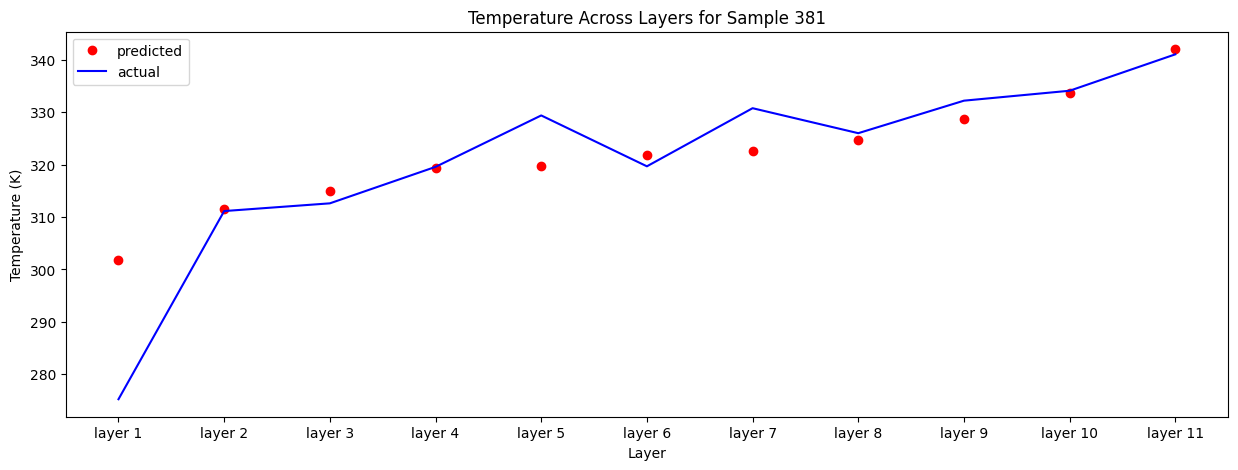

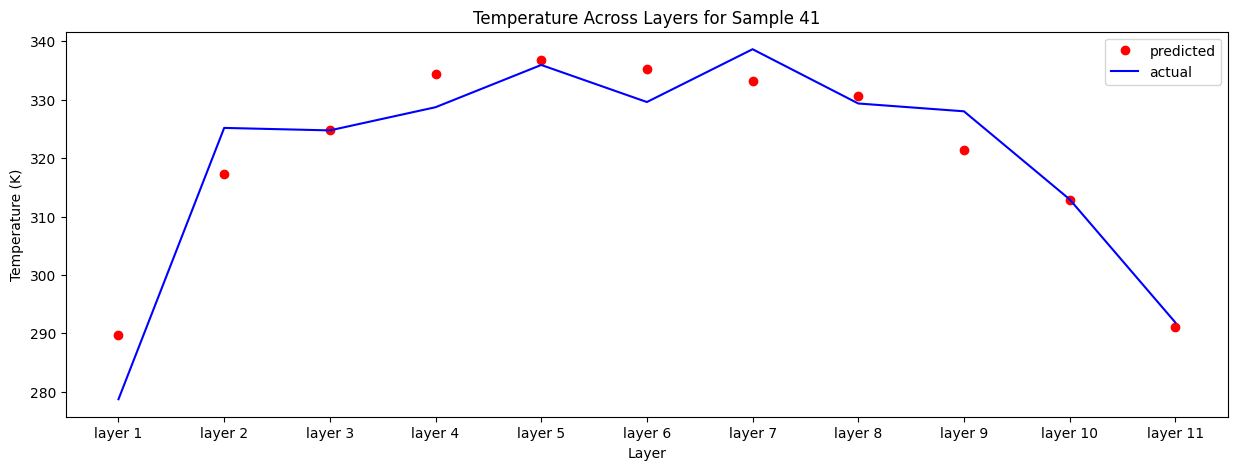

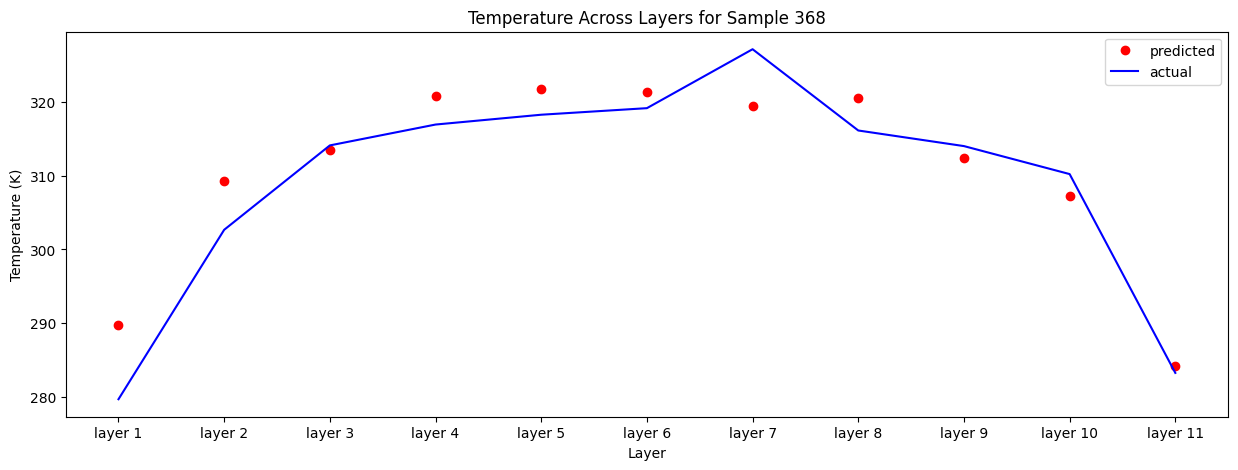

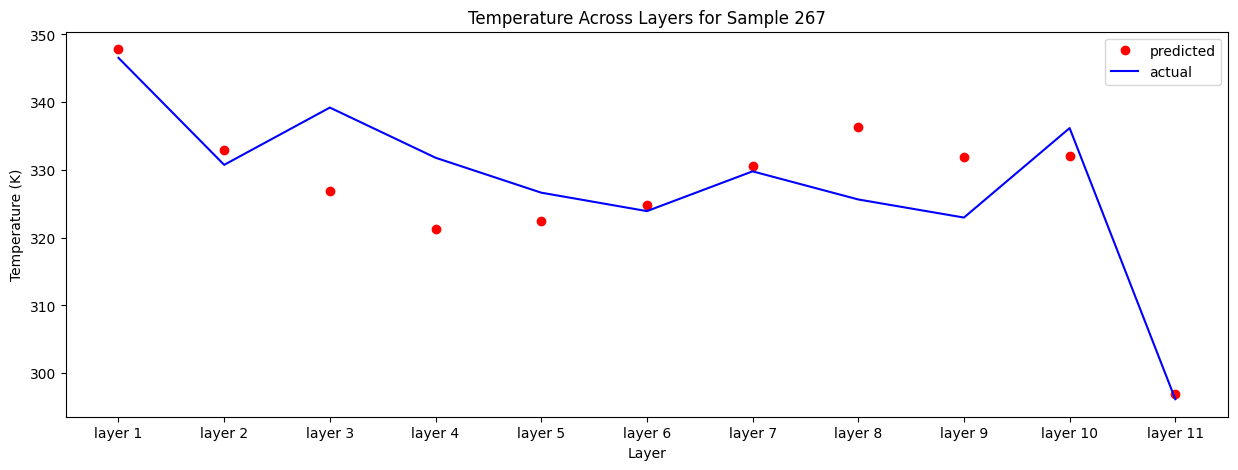

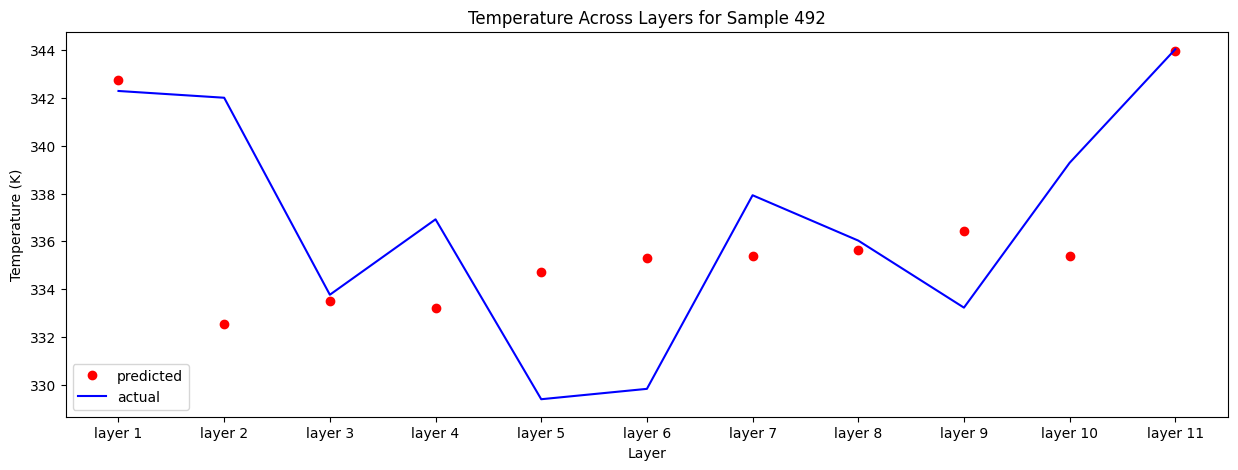

In [178]:
indices = []
for i in range(0,5):
    n = random.randint(0, len(y_test))
    indices.append(n)

for i in indices:
    actual = actual_df.iloc[i,:]
    pred = pred_df.iloc[i,:]

    plot_comparison(pred, actual, i)